In [41]:
#!/usr/bin/env python3
"""
Visualization script for k-tuple demonstration results.
Compares best, worst, random, and optimized demonstrations with no-demonstration baseline.
Loads 1-shot, 2-shot, 4-shot, and optimized results.
"""

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
from glob import glob

# Set the style for beautiful plots
plt.style.use('seaborn-v0_8-darkgrid')

# Configure matplotlib for better aesthetics
plt.rcParams['figure.figsize'] = (14, 10)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['xtick.labelsize'] = 11
plt.rcParams['ytick.labelsize'] = 11
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['figure.titlesize'] = 18

# Load the results for 1-shot, 2-shot, and 4-shot
persona_id = "cdf7cefb-7341-41d7-a193-ff0f2f962cf9"

# 1-shot results from icl_gain_results directory
print("Loading 1-shot results from icl_gain_results/...")

# Load no_context baseline
no_context_file = f"icl_gain_results/test_accuracy_no_context_demo_{persona_id}.npz"
data_no_context = np.load(no_context_file, allow_pickle=True)

# Load best_rank 1-5
best_rank_files = [f"icl_gain_results/test_accuracy_best_rank{i}_demo_{persona_id}.npz" for i in range(1, 6)]
data_best_ranks = [np.load(f, allow_pickle=True) for f in best_rank_files]

# Load worst_rank 1-5
worst_rank_files = [f"icl_gain_results/test_accuracy_worst_rank{i}_demo_{persona_id}.npz" for i in range(1, 6)]
data_worst_ranks = [np.load(f, allow_pickle=True) for f in worst_rank_files]

# Load random_num 1-5
random_files = [f"icl_gain_results/test_accuracy_random_num{i}_demo_{persona_id}.npz" for i in range(1, 6)]
data_randoms = [np.load(f, allow_pickle=True) for f in random_files]

print(f"Loaded 1-shot: {len(data_best_ranks)} best_rank, {len(data_worst_ranks)} worst_rank, {len(data_randoms)} random")

# 2-shot results
results_file_2shot = f"icl_diy_pair_test_results/icl_pair_test_results_{persona_id}.npz"
print(f"Loading 2-shot results from: {results_file_2shot}")
data_2shot = np.load(results_file_2shot, allow_pickle=True)

# 4-shot results
results_file_4shot = f"icl_ktuple_test_results/icl_ktuple_test_results_k4_{persona_id}.npz"
print(f"Loading 4-shot results from: {results_file_4shot}")
data_4shot = np.load(results_file_4shot, allow_pickle=True)

# Optimized context results
optimized_file = f"icl_optimized_results/optimized_contexts_{persona_id}.npz"
print(f"Loading optimized context results from: {optimized_file}")
data_optimized = np.load(optimized_file, allow_pickle=True)
print(f"Loaded optimized contexts with k={data_optimized['k']}, n_runs={data_optimized['optimized_contexts'].shape[0]}")

# Function to process 1-shot data
def process_1shot_data(data_best, data_worst, data_random, data_no_ctx):
    """Process 1-shot data from separate files and return statistics.
    
    NOTE: Uses avg_prob_per_test for computing probabilities and accuracy.
    SNR is computed as mean(log_prob_gain) / std(log_prob_gain).
    """
    
    # Compute log probabilities for no_context baseline
    probs_no_context = data_no_ctx['avg_prob_per_test']
    log_probs_no_context = np.log(probs_no_context + 1e-10)  # Add small epsilon to avoid log(0)
    accuracy_no_context = (probs_no_context > 0.5).astype(float)
    
    # Compute statistics for best demonstrations (5 ranks)
    best_accs = []
    best_probs = []
    best_log_probs = []
    for data in data_best:
        probs = data['avg_prob_per_test']
        log_probs = np.log(probs + 1e-10)
        acc = (probs > 0.5).astype(float)
        best_accs.append(acc)
        best_probs.append(probs)
        best_log_probs.append(log_probs)
    
    # Compute statistics for worst demonstrations (5 ranks)
    worst_accs = []
    worst_probs = []
    worst_log_probs = []
    for data in data_worst:
        probs = data['avg_prob_per_test']
        log_probs = np.log(probs + 1e-10)
        acc = (probs > 0.5).astype(float)
        worst_accs.append(acc)
        worst_probs.append(probs)
        worst_log_probs.append(log_probs)
    
    # Compute statistics for random demonstrations (5 samples)
    random_accs = []
    random_probs = []
    random_log_probs = []
    for data in data_random:
        probs = data['avg_prob_per_test']
        log_probs = np.log(probs + 1e-10)
        acc = (probs > 0.5).astype(float)
        random_accs.append(acc)
        random_probs.append(probs)
        random_log_probs.append(log_probs)
    
    # Stack into arrays
    best_probs = np.array(best_probs) * 100  # Convert to percentage
    best_accs = np.array(best_accs) * 100
    best_log_probs = np.array(best_log_probs)
    
    worst_probs = np.array(worst_probs) * 100
    worst_accs = np.array(worst_accs) * 100
    worst_log_probs = np.array(worst_log_probs)
    
    random_probs = np.array(random_probs) * 100
    random_accs = np.array(random_accs) * 100
    random_log_probs = np.array(random_log_probs)
    
    probs_no_context = probs_no_context * 100
    accuracy_no_context = accuracy_no_context * 100
    
    # Compute log probability gains
    # Shape: (n_demos, n_test) for each category
    best_log_prob_gain = best_log_probs - log_probs_no_context  # Broadcasting: (5, 512) - (512,) = (5, 512)
    worst_log_prob_gain = worst_log_probs - log_probs_no_context
    random_log_prob_gain = random_log_probs - log_probs_no_context
    
    # Compute SNR for each category: mean(gain) / std(gain)
    best_snr = best_log_prob_gain.mean() / best_log_prob_gain.std() if best_log_prob_gain.std() > 0 else float('inf')
    worst_snr = worst_log_prob_gain.mean() / worst_log_prob_gain.std() if worst_log_prob_gain.std() > 0 else float('inf')
    random_snr = random_log_prob_gain.mean() / random_log_prob_gain.std() if random_log_prob_gain.std() > 0 else float('inf')
    
    category_stats = {
        'best': {
            'mean_prob': best_probs.mean(),
            'std_prob': best_probs.std(),
            'mean_accuracy': best_accs.mean(),
            'std_accuracy': best_accs.std(),
            'prob_snr': best_snr,
        },
        'worst': {
            'mean_prob': worst_probs.mean(),
            'std_prob': worst_probs.std(),
            'mean_accuracy': worst_accs.mean(),
            'std_accuracy': worst_accs.std(),
            'prob_snr': worst_snr,
        },
        'random': {
            'mean_prob': random_probs.mean(),
            'std_prob': random_probs.std(),
            'mean_accuracy': random_accs.mean(),
            'std_accuracy': random_accs.std(),
            'prob_snr': random_snr,
        },
        'no_demo': {
            'mean_prob': probs_no_context.mean(),
            'std_prob': probs_no_context.std(),
            'mean_accuracy': accuracy_no_context.mean(),
            'std_accuracy': accuracy_no_context.std(),
            'prob_snr': 0.0,  # No gain for baseline
        }
    }
    
    # Add accuracy gain
    baseline_acc = accuracy_no_context.mean()
    category_stats['best']['mean_acc_gain'] = category_stats['best']['mean_accuracy'] - baseline_acc
    category_stats['best']['std_acc_gain'] = best_accs.std()
    category_stats['worst']['mean_acc_gain'] = category_stats['worst']['mean_accuracy'] - baseline_acc
    category_stats['worst']['std_acc_gain'] = worst_accs.std()
    category_stats['random']['mean_acc_gain'] = category_stats['random']['mean_accuracy'] - baseline_acc
    category_stats['random']['std_acc_gain'] = random_accs.std()
    category_stats['no_demo']['mean_acc_gain'] = 0.0
    category_stats['no_demo']['std_acc_gain'] = 0.0
    
    return category_stats, best_probs, worst_probs, random_probs, probs_no_context, best_accs, worst_accs, random_accs, accuracy_no_context

# Function to process 2-shot/4-shot data
def process_data(data, k_shot):
    """Process data from npz file and return statistics.
    
    NOTE: Accuracy is computed from log probabilities using (exp(log_prob) > 0.5).mean()
    instead of using the stored accuracy values.
    SNR is computed as mean(log_prob_gain) / std(log_prob_gain).
    """
    tuple_categories = data['tuple_categories'] if 'tuple_categories' in data else data['pair_categories']
    log_probs_with_context = data['log_probs_with_context']
    log_probs_no_context = data['log_probs_no_context']
    
    # Compute probabilities from log probabilities
    probs_with_context = np.exp(log_probs_with_context)
    probs_no_context = np.exp(log_probs_no_context)
    
    # IMPORTANT: Compute accuracy from probabilities instead of using stored values
    # accuracy = (prob > 0.5).astype(float)
    accuracy_with_context = (probs_with_context > 0.5).astype(float)
    accuracy_no_context = (probs_no_context > 0.5).astype(float)
    accuracy_gain = accuracy_with_context - accuracy_no_context
    
    # Compute log probability gain
    # Shape: (n_tuples, n_test) - (n_test,) = (n_tuples, n_test)
    log_prob_gain = log_probs_with_context - log_probs_no_context
    
    # Compute statistics for each category
    categories = ['best', 'worst', 'random']
    category_stats = {}
    
    for category in categories:
        category_mask = np.array([cat == category for cat in tuple_categories])
        category_indices = np.where(category_mask)[0]
        
        # Get gains for this category
        category_log_prob_gain = log_prob_gain[category_indices, :]
        
        # Compute SNR: mean(gain) / std(gain)
        gain_mean = category_log_prob_gain.mean()
        gain_std = category_log_prob_gain.std()
        prob_snr = gain_mean / gain_std if gain_std > 0 else float('inf')
        
        category_stats[category] = {
            'mean_prob': probs_with_context[category_indices, :].mean() * 100,
            'std_prob': probs_with_context[category_indices, :].std() * 100,
            'mean_accuracy': accuracy_with_context[category_indices, :].mean() * 100,
            'std_accuracy': accuracy_with_context[category_indices, :].std() * 100,
            'mean_acc_gain': accuracy_gain[category_indices, :].mean() * 100,
            'std_acc_gain': accuracy_gain[category_indices, :].std() * 100,
            'prob_snr': prob_snr,
        }
    
    # Add no-context baseline statistics
    category_stats['no_demo'] = {
        'mean_prob': probs_no_context.mean() * 100,
        'std_prob': probs_no_context.std() * 100,
        'mean_accuracy': accuracy_no_context.mean() * 100,
        'std_accuracy': accuracy_no_context.std() * 100,
        'mean_acc_gain': 0.0,
        'std_acc_gain': 0.0,
        'prob_snr': 0.0,  # No gain for baseline
    }
    
    return category_stats, tuple_categories, probs_with_context, probs_no_context, accuracy_with_context, accuracy_no_context

# Function to process optimized context data
def process_optimized_data(data):
    """Process optimized context data.
    
    NOTE: Uses stored log probabilities and computes accuracy.
    SNR is computed as mean(log_prob_gain) / std(log_prob_gain).
    """
    log_probs_with_context = data['log_probs_with_context']  # Shape: (n_runs, n_test)
    log_probs_no_context = data['log_probs_no_context']  # Shape: (n_test,)
    
    # Compute probabilities from log probabilities
    probs_with_context = np.exp(log_probs_with_context)
    probs_no_context = np.exp(log_probs_no_context)
    
    # Compute accuracy from probabilities
    accuracy_with_context = (probs_with_context > 0.5).astype(float)
    accuracy_no_context = (probs_no_context > 0.5).astype(float)
    accuracy_gain = accuracy_with_context - accuracy_no_context
    
    # Compute log probability gain
    log_prob_gain = log_probs_with_context - log_probs_no_context
    
    # Compute SNR: mean(gain) / std(gain) across all runs and test examples
    gain_mean = log_prob_gain.mean()
    gain_std = log_prob_gain.std()
    prob_snr = gain_mean / gain_std if gain_std > 0 else float('inf')
    
    optimized_stats = {
        'mean_prob': probs_with_context.mean() * 100,
        'std_prob': probs_with_context.std() * 100,
        'mean_accuracy': accuracy_with_context.mean() * 100,
        'std_accuracy': accuracy_with_context.std() * 100,
        'mean_acc_gain': accuracy_gain.mean() * 100,
        'std_acc_gain': accuracy_gain.std() * 100,
        'prob_snr': prob_snr,
    }
    
    return optimized_stats, probs_with_context, accuracy_with_context

# Process 1-shot data
print("\n" + "="*80)
print("Processing 1-shot data...")
stats_1shot, best_probs_1shot, worst_probs_1shot, random_probs_1shot, probs_no_1shot, \
    best_acc_1shot, worst_acc_1shot, random_acc_1shot, acc_no_1shot = process_1shot_data(
        data_best_ranks, data_worst_ranks, data_randoms, data_no_context)

# Process 2-shot and 4-shot datasets
print("Processing 2-shot data...")
stats_2shot, categories_2shot, probs_2shot, probs_no_2shot, acc_2shot, acc_no_2shot = process_data(data_2shot, 2)

print("Processing 4-shot data...")
stats_4shot, categories_4shot, probs_4shot, probs_no_4shot, acc_4shot, acc_no_4shot = process_data(data_4shot, 4)

# Process optimized context data
print("Processing optimized context data...")
stats_optimized, probs_optimized, acc_optimized = process_optimized_data(data_optimized)
# Add to 4-shot stats as a new category
stats_4shot['optimized'] = stats_optimized

# Print statistics
print("\n" + "="*80)
print("1-SHOT Statistics")
print("="*80)
for category in ['no_demo', 'best', 'worst', 'random']:
    stats = stats_1shot[category]
    print(f"\n{category.upper()}:")
    print(f"  Mean probability: {stats['mean_prob']:.2f}% ± {stats['std_prob']:.2f}%")
    print(f"  Mean accuracy:    {stats['mean_accuracy']:.2f}% ± {stats['std_accuracy']:.2f}%")
    print(f"  Mean acc gain:    {stats['mean_acc_gain']:.2f}% ± {stats['std_acc_gain']:.2f}%")
    print(f"  Prob SNR:         {stats['prob_snr']:.3f}")

print("\n" + "="*80)
print("2-SHOT Statistics")
print("="*80)
for category in ['no_demo', 'best', 'worst', 'random']:
    stats = stats_2shot[category]
    print(f"\n{category.upper()}:")
    print(f"  Mean probability: {stats['mean_prob']:.2f}% ± {stats['std_prob']:.2f}%")
    print(f"  Mean accuracy:    {stats['mean_accuracy']:.2f}% ± {stats['std_accuracy']:.2f}%")
    print(f"  Mean acc gain:    {stats['mean_acc_gain']:.2f}% ± {stats['std_acc_gain']:.2f}%")
    print(f"  Prob SNR:         {stats['prob_snr']:.3f}")

print("\n" + "="*80)
print("4-SHOT Statistics")
print("="*80)
for category in ['no_demo', 'best', 'worst', 'random', 'optimized']:
    stats = stats_4shot[category]
    print(f"\n{category.upper()}:")
    print(f"  Mean probability: {stats['mean_prob']:.2f}% ± {stats['std_prob']:.2f}%")
    print(f"  Mean accuracy:    {stats['mean_accuracy']:.2f}% ± {stats['std_accuracy']:.2f}%")
    print(f"  Mean acc gain:    {stats['mean_acc_gain']:.2f}% ± {stats['std_acc_gain']:.2f}%")
    print(f"  Prob SNR:         {stats['prob_snr']:.3f}")

Loading 1-shot results from icl_gain_results/...
Loaded 1-shot: 5 best_rank, 5 worst_rank, 5 random
Loading 2-shot results from: icl_diy_pair_test_results/icl_pair_test_results_cdf7cefb-7341-41d7-a193-ff0f2f962cf9.npz
Loading 4-shot results from: icl_ktuple_test_results/icl_ktuple_test_results_k4_cdf7cefb-7341-41d7-a193-ff0f2f962cf9.npz
Loading optimized context results from: icl_optimized_results/optimized_contexts_cdf7cefb-7341-41d7-a193-ff0f2f962cf9.npz
Loaded optimized contexts with k=4, n_runs=3

Processing 1-shot data...
Processing 2-shot data...
Processing 4-shot data...
Processing optimized context data...

1-SHOT Statistics

NO_DEMO:
  Mean probability: 56.58% ± 15.98%
  Mean accuracy:    67.77% ± 46.73%
  Mean acc gain:    0.00% ± 0.00%
  Prob SNR:         0.000

BEST:
  Mean probability: 59.51% ± 19.54%
  Mean accuracy:    71.13% ± 45.31%
  Mean acc gain:    3.36% ± 45.31%
  Prob SNR:         0.099

WORST:
  Mean probability: 56.44% ± 14.00%
  Mean accuracy:    70.62% ± 45.5

In [42]:
(data_best_ranks[0]['avg_prob_per_test']>0.5).mean()

0.7265625


Boxplot results saved to: boxplot_1to4shot_with_optimized_cdf7cefb.png


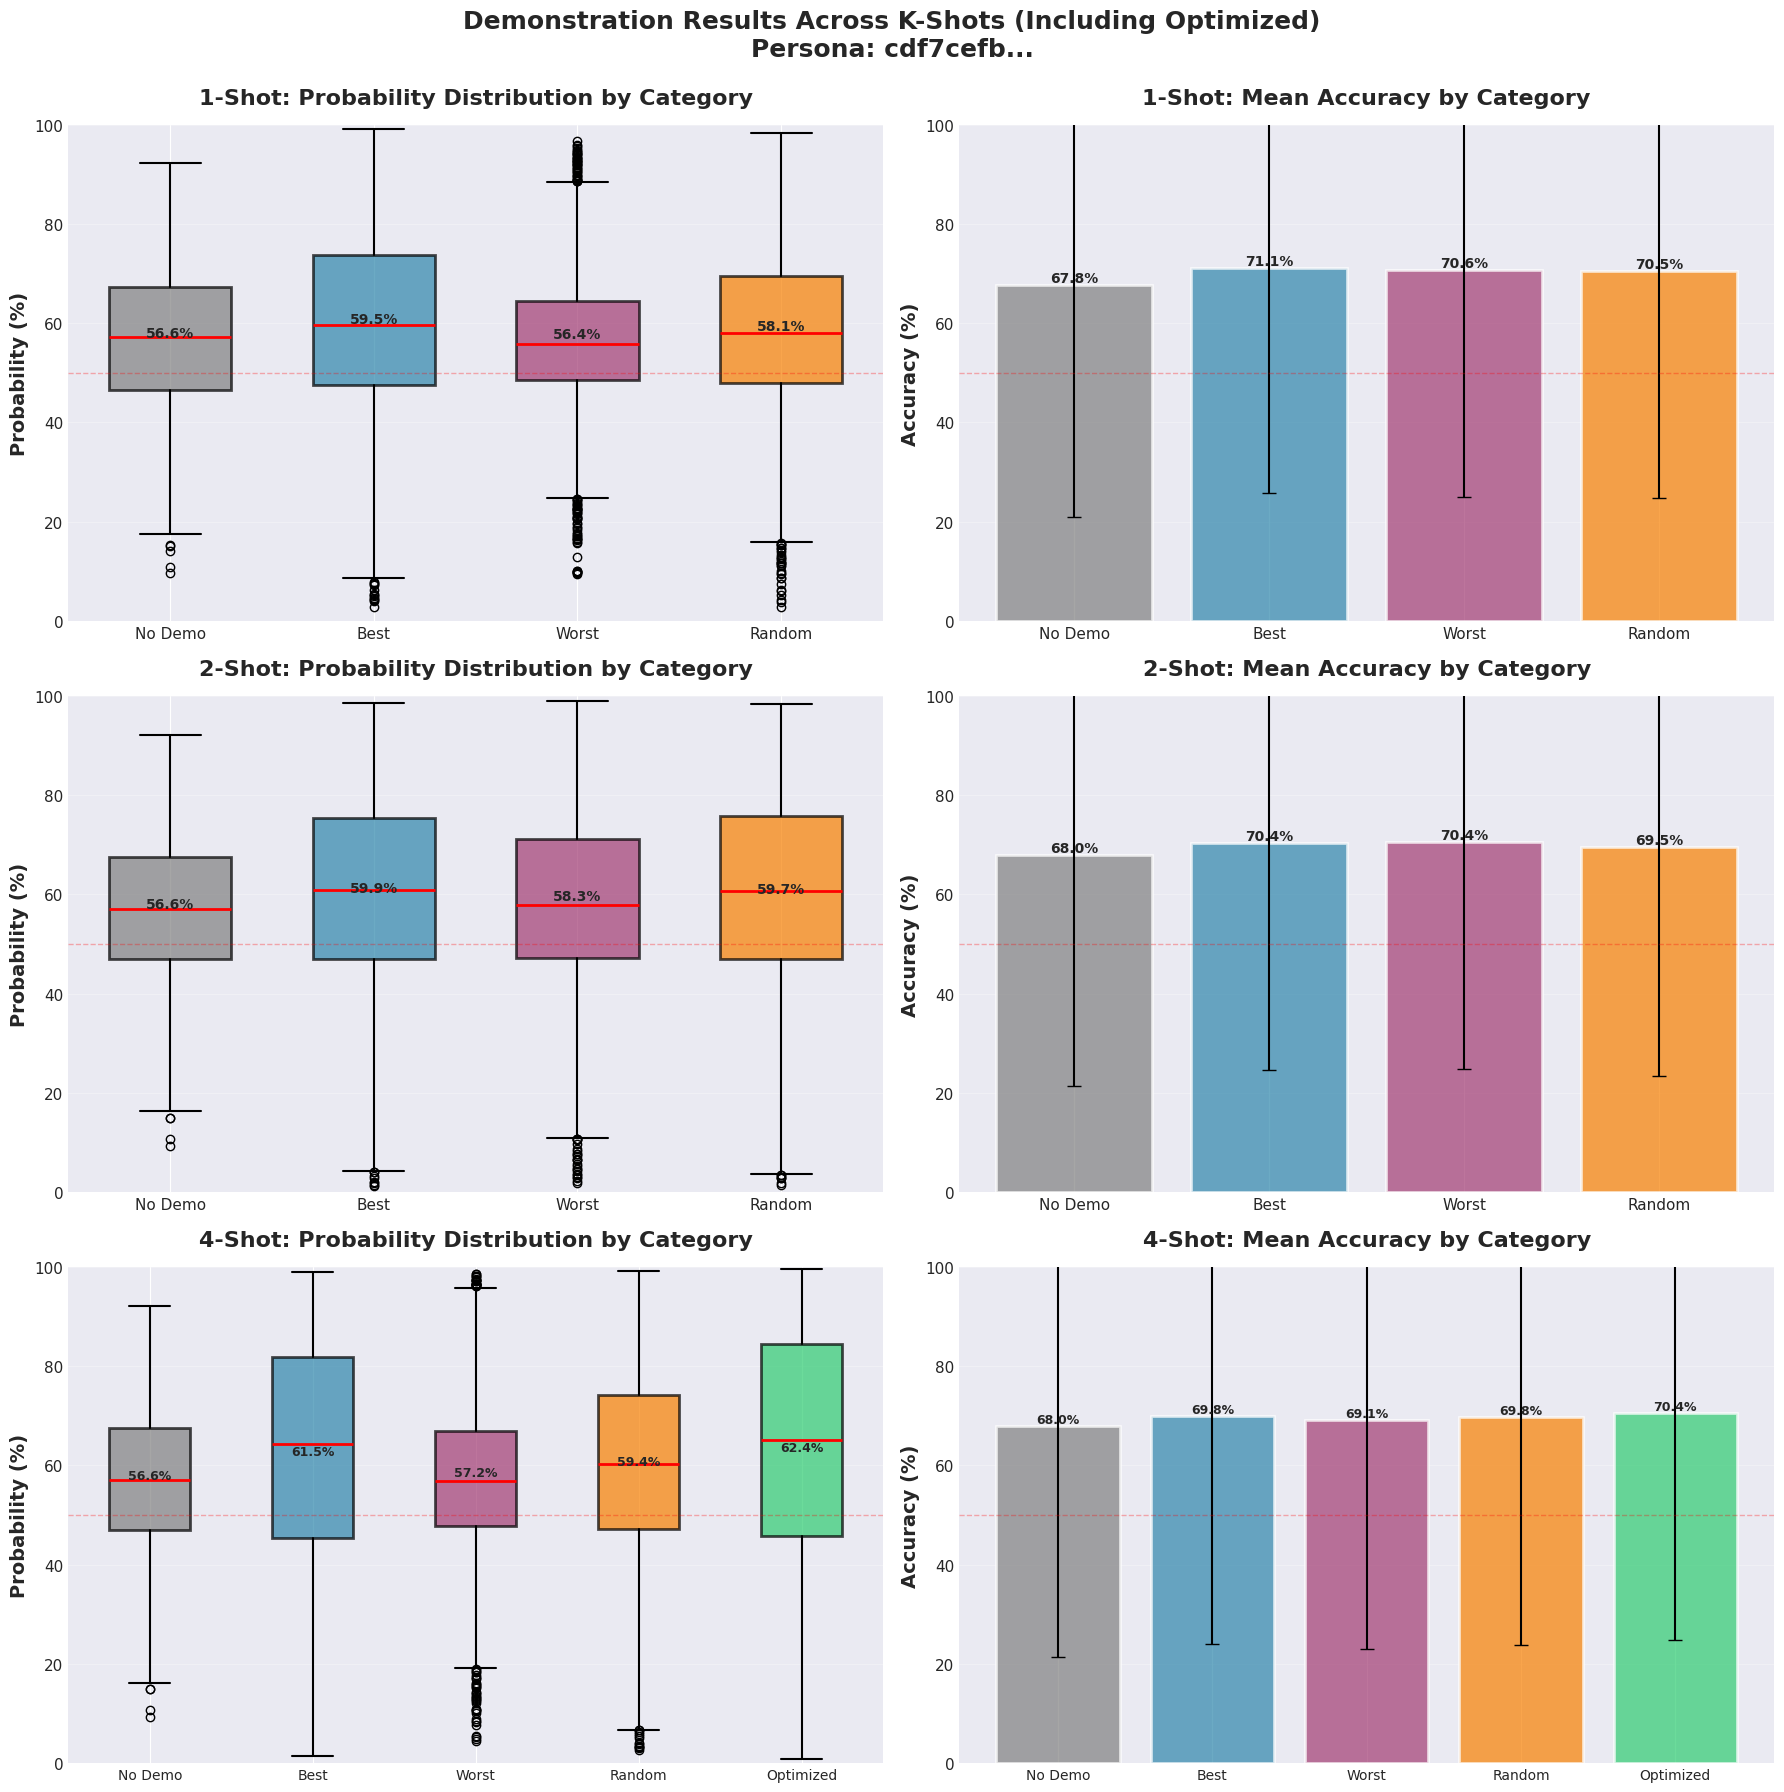


Visualization complete!


In [43]:
# Create visualization for 1-shot, 2-shot, and 4-shot results
# Boxplot for probability (continuous), bar chart for accuracy (binary)
fig, axes = plt.subplots(3, 2, figsize=(18, 18))

# Define colors for each category
colors = {
    'no_demo': '#808080',  # Gray
    'best': '#2E86AB',     # Blue
    'worst': '#A23B72',    # Purple
    'random': '#F77F00',   # Orange
    'optimized': '#2ECC71' # Green
}

category_labels = {
    'no_demo': 'No Demo',
    'best': 'Best',
    'worst': 'Worst',
    'random': 'Random',
    'optimized': 'Optimized'
}

categories_plot = ['no_demo', 'best', 'worst', 'random']
categories_plot_4shot = ['no_demo', 'best', 'worst', 'random', 'optimized']

# ============================================================================
# 1-SHOT RESULTS
# ============================================================================
# Prepare data for boxplots - 1-shot
prob_data_1shot = []

# No demo data
prob_data_1shot.append(probs_no_1shot.flatten())

# Best, worst, random
prob_data_1shot.append(best_probs_1shot.flatten())
prob_data_1shot.append(worst_probs_1shot.flatten())
prob_data_1shot.append(random_probs_1shot.flatten())

# Plot probability boxplot - 1-shot
ax = axes[0, 0]
bp = ax.boxplot(prob_data_1shot, labels=[category_labels[cat] for cat in categories_plot],
                patch_artist=True, widths=0.6,
                boxprops=dict(linewidth=2),
                medianprops=dict(color='red', linewidth=2),
                whiskerprops=dict(linewidth=1.5),
                capprops=dict(linewidth=1.5))

for patch, category in zip(bp['boxes'], categories_plot):
    patch.set_facecolor(colors[category])
    patch.set_alpha(0.7)

ax.set_ylabel('Probability (%)', fontweight='bold', fontsize=14)
ax.set_title('1-Shot: Probability Distribution by Category', fontweight='bold', fontsize=16, pad=15)
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim(0, 100)
ax.axhline(y=50, color='red', linestyle='--', linewidth=1, alpha=0.3, label='Random chance')

# Add mean probability labels on boxplot
for i, category in enumerate(categories_plot):
    mean_prob = stats_1shot[category]['mean_prob']
    ax.text(i + 1, mean_prob, f'{mean_prob:.1f}%',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

# Plot accuracy bar chart - 1-shot
ax = axes[0, 1]
x_pos = np.arange(len(categories_plot))
means = [stats_1shot[cat]['mean_accuracy'] for cat in categories_plot]
stds = [stats_1shot[cat]['std_accuracy'] for cat in categories_plot]

bars = ax.bar(x_pos, means, yerr=stds, capsize=5, alpha=0.7, edgecolor='white', linewidth=2)

for bar, category in zip(bars, categories_plot):
    bar.set_facecolor(colors[category])

ax.set_ylabel('Accuracy (%)', fontweight='bold', fontsize=14)
ax.set_title('1-Shot: Mean Accuracy by Category', fontweight='bold', fontsize=16, pad=15)
ax.set_xticks(x_pos)
ax.set_xticklabels([category_labels[cat] for cat in categories_plot])
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim(0, 100)
ax.axhline(y=50, color='red', linestyle='--', linewidth=1, alpha=0.3, label='Random chance')

# Add value labels on bars
for i, (bar, mean) in enumerate(zip(bars, means)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{mean:.1f}%',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

# ============================================================================
# 2-SHOT RESULTS
# ============================================================================
# Prepare data for boxplots - 2-shot
prob_data_2shot = []

# No demo data
prob_data_2shot.append(probs_no_2shot.flatten() * 100)

# Best, worst, random
for category in ['best', 'worst', 'random']:
    category_mask = np.array([cat == category for cat in categories_2shot])
    category_indices = np.where(category_mask)[0]
    
    prob_data_2shot.append(probs_2shot[category_indices, :].flatten() * 100)

# Plot probability boxplot - 2-shot
ax = axes[1, 0]
bp = ax.boxplot(prob_data_2shot, labels=[category_labels[cat] for cat in categories_plot],
                patch_artist=True, widths=0.6,
                boxprops=dict(linewidth=2),
                medianprops=dict(color='red', linewidth=2),
                whiskerprops=dict(linewidth=1.5),
                capprops=dict(linewidth=1.5))

for patch, category in zip(bp['boxes'], categories_plot):
    patch.set_facecolor(colors[category])
    patch.set_alpha(0.7)

ax.set_ylabel('Probability (%)', fontweight='bold', fontsize=14)
ax.set_title('2-Shot: Probability Distribution by Category', fontweight='bold', fontsize=16, pad=15)
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim(0, 100)
ax.axhline(y=50, color='red', linestyle='--', linewidth=1, alpha=0.3, label='Random chance')

# Add mean probability labels on boxplot
for i, category in enumerate(categories_plot):
    mean_prob = stats_2shot[category]['mean_prob']
    ax.text(i + 1, mean_prob, f'{mean_prob:.1f}%',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

# Plot accuracy bar chart - 2-shot
ax = axes[1, 1]
x_pos = np.arange(len(categories_plot))
means = [stats_2shot[cat]['mean_accuracy'] for cat in categories_plot]
stds = [stats_2shot[cat]['std_accuracy'] for cat in categories_plot]

bars = ax.bar(x_pos, means, yerr=stds, capsize=5, alpha=0.7, edgecolor='white', linewidth=2)

for bar, category in zip(bars, categories_plot):
    bar.set_facecolor(colors[category])

ax.set_ylabel('Accuracy (%)', fontweight='bold', fontsize=14)
ax.set_title('2-Shot: Mean Accuracy by Category', fontweight='bold', fontsize=16, pad=15)
ax.set_xticks(x_pos)
ax.set_xticklabels([category_labels[cat] for cat in categories_plot])
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim(0, 100)
ax.axhline(y=50, color='red', linestyle='--', linewidth=1, alpha=0.3, label='Random chance')

# Add value labels on bars
for i, (bar, mean) in enumerate(zip(bars, means)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{mean:.1f}%',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

# ============================================================================
# 4-SHOT RESULTS (Including Optimized)
# ============================================================================
# Prepare data for boxplots - 4-shot
prob_data_4shot = []

# No demo data
prob_data_4shot.append(probs_no_4shot.flatten() * 100)

# Best, worst, random
for category in ['best', 'worst', 'random']:
    category_mask = np.array([cat == category for cat in categories_4shot])
    category_indices = np.where(category_mask)[0]
    
    prob_data_4shot.append(probs_4shot[category_indices, :].flatten() * 100)

# Optimized
prob_data_4shot.append(probs_optimized.flatten() * 100)

# Plot probability boxplot - 4-shot
ax = axes[2, 0]
bp = ax.boxplot(prob_data_4shot, labels=[category_labels[cat] for cat in categories_plot_4shot],
                patch_artist=True, widths=0.5,
                boxprops=dict(linewidth=2),
                medianprops=dict(color='red', linewidth=2),
                whiskerprops=dict(linewidth=1.5),
                capprops=dict(linewidth=1.5))

for patch, category in zip(bp['boxes'], categories_plot_4shot):
    patch.set_facecolor(colors[category])
    patch.set_alpha(0.7)

ax.set_ylabel('Probability (%)', fontweight='bold', fontsize=14)
ax.set_title('4-Shot: Probability Distribution by Category', fontweight='bold', fontsize=16, pad=15)
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim(0, 100)
ax.axhline(y=50, color='red', linestyle='--', linewidth=1, alpha=0.3, label='Random chance')
ax.tick_params(axis='x', labelsize=10)

# Add mean probability labels on boxplot
for i, category in enumerate(categories_plot_4shot):
    mean_prob = stats_4shot[category]['mean_prob']
    ax.text(i + 1, mean_prob, f'{mean_prob:.1f}%',
            ha='center', va='bottom', fontsize=9, fontweight='bold')

# Plot accuracy bar chart - 4-shot
ax = axes[2, 1]
x_pos = np.arange(len(categories_plot_4shot))
means = [stats_4shot[cat]['mean_accuracy'] for cat in categories_plot_4shot]
stds = [stats_4shot[cat]['std_accuracy'] for cat in categories_plot_4shot]

bars = ax.bar(x_pos, means, yerr=stds, capsize=5, alpha=0.7, edgecolor='white', linewidth=2)

for bar, category in zip(bars, categories_plot_4shot):
    bar.set_facecolor(colors[category])

ax.set_ylabel('Accuracy (%)', fontweight='bold', fontsize=14)
ax.set_title('4-Shot: Mean Accuracy by Category', fontweight='bold', fontsize=16, pad=15)
ax.set_xticks(x_pos)
ax.set_xticklabels([category_labels[cat] for cat in categories_plot_4shot])
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim(0, 100)
ax.axhline(y=50, color='red', linestyle='--', linewidth=1, alpha=0.3, label='Random chance')
ax.tick_params(axis='x', labelsize=10)

# Add value labels on bars
for i, (bar, mean) in enumerate(zip(bars, means)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{mean:.1f}%',
            ha='center', va='bottom', fontsize=9, fontweight='bold')

fig.suptitle(f'Demonstration Results Across K-Shots (Including Optimized)\nPersona: {persona_id[:8]}...',
             fontweight='bold', fontsize=18, y=0.995)

plt.tight_layout()

# Save the figure
output_path = f'boxplot_1to4shot_with_optimized_{persona_id[:8]}.png'
plt.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='white')
print(f"\nBoxplot results saved to: {output_path}")

plt.show()

print("\n" + "="*80)
print("Visualization complete!")
print("="*80)


Trends figure saved to: trends_1shot_to_4shot_with_optimized_cdf7cefb.png


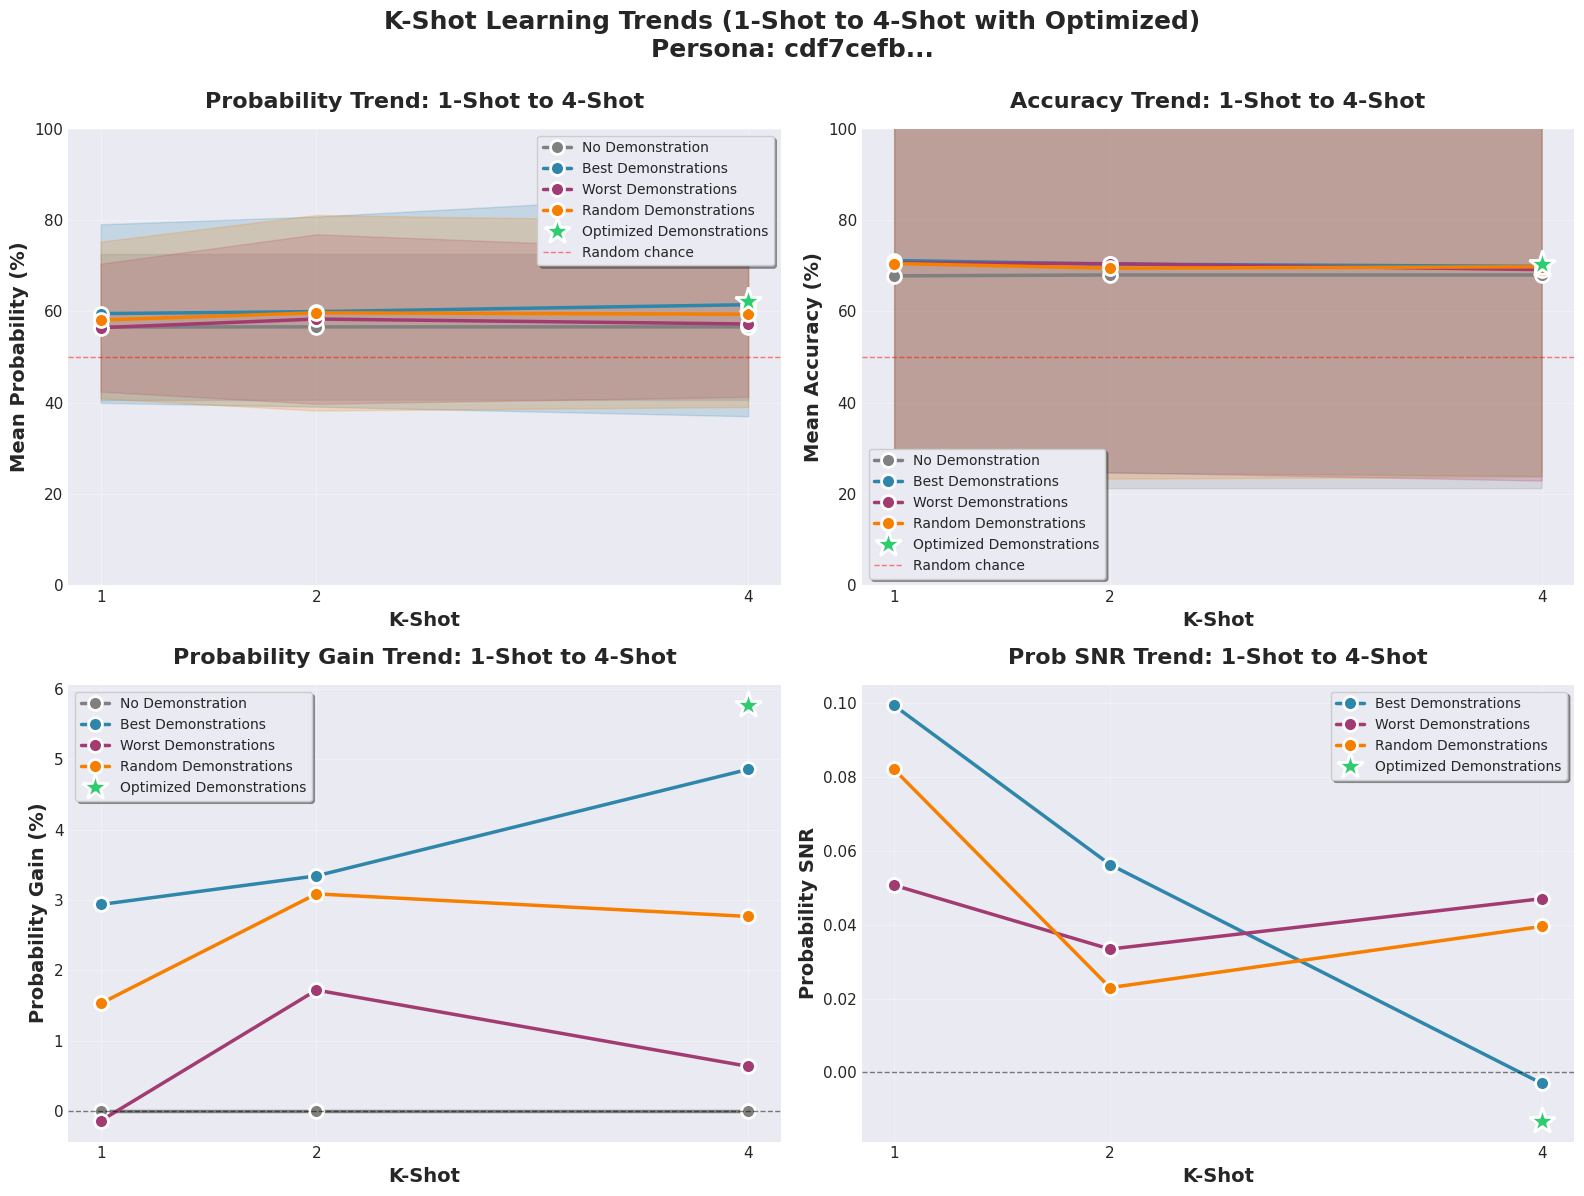

In [44]:
# Line plot showing trends from 1-shot to 2-shot to 4-shot (with optimized)
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Define colors for each category
colors = {
    'no_demo': '#808080',  # Gray
    'best': '#2E86AB',     # Blue
    'worst': '#A23B72',    # Purple
    'random': '#F77F00',   # Orange
    'optimized': '#2ECC71' # Green
}

category_labels = {
    'no_demo': 'No Demonstration',
    'best': 'Best Demonstrations',
    'worst': 'Worst Demonstrations',
    'random': 'Random Demonstrations',
    'optimized': 'Optimized Demonstrations'
}

categories_plot = ['no_demo', 'best', 'worst', 'random']
k_shots = [1, 2, 4]

# Plot 1: Probability trend
ax = axes[0, 0]
for category in categories_plot:
    means = [stats_1shot[category]['mean_prob'], 
             stats_2shot[category]['mean_prob'], 
             stats_4shot[category]['mean_prob']]
    stds = [stats_1shot[category]['std_prob'], 
            stats_2shot[category]['std_prob'], 
            stats_4shot[category]['std_prob']]
    
    ax.plot(k_shots, means, marker='o', linewidth=2.5, markersize=10,
            color=colors[category], label=category_labels[category],
            markeredgewidth=2, markeredgecolor='white')
    ax.fill_between(k_shots, 
                    [m - s for m, s in zip(means, stds)], 
                    [m + s for m, s in zip(means, stds)],
                    alpha=0.2, color=colors[category])

# Add optimized as a single point at 4-shot
ax.plot([4], [stats_4shot['optimized']['mean_prob']], marker='*', markersize=20,
        color=colors['optimized'], label=category_labels['optimized'],
        markeredgewidth=2, markeredgecolor='white', linestyle='none')

ax.set_xlabel('K-Shot', fontweight='bold')
ax.set_ylabel('Mean Probability (%)', fontweight='bold')
ax.set_title('Probability Trend: 1-Shot to 4-Shot', fontweight='bold', pad=15)
ax.set_xticks(k_shots)
ax.grid(True, alpha=0.3)
ax.axhline(y=50, color='red', linestyle='--', linewidth=1, alpha=0.5, label='Random chance')
ax.legend(loc='best', frameon=True, shadow=True, fontsize=10)
ax.set_ylim(0, 100)

# Plot 2: Accuracy trend
ax = axes[0, 1]
for category in categories_plot:
    means = [stats_1shot[category]['mean_accuracy'], 
             stats_2shot[category]['mean_accuracy'], 
             stats_4shot[category]['mean_accuracy']]
    stds = [stats_1shot[category]['std_accuracy'], 
            stats_2shot[category]['std_accuracy'], 
            stats_4shot[category]['std_accuracy']]
    
    ax.plot(k_shots, means, marker='o', linewidth=2.5, markersize=10,
            color=colors[category], label=category_labels[category],
            markeredgewidth=2, markeredgecolor='white')
    ax.fill_between(k_shots, 
                    [m - s for m, s in zip(means, stds)], 
                    [m + s for m, s in zip(means, stds)],
                    alpha=0.2, color=colors[category])

# Add optimized as a single point at 4-shot
ax.plot([4], [stats_4shot['optimized']['mean_accuracy']], marker='*', markersize=20,
        color=colors['optimized'], label=category_labels['optimized'],
        markeredgewidth=2, markeredgecolor='white', linestyle='none')

ax.set_xlabel('K-Shot', fontweight='bold')
ax.set_ylabel('Mean Accuracy (%)', fontweight='bold')
ax.set_title('Accuracy Trend: 1-Shot to 4-Shot', fontweight='bold', pad=15)
ax.set_xticks(k_shots)
ax.grid(True, alpha=0.3)
ax.axhline(y=50, color='red', linestyle='--', linewidth=1, alpha=0.5, label='Random chance')
ax.legend(loc='best', frameon=True, shadow=True, fontsize=10)
ax.set_ylim(0, 100)

# Plot 3: Probability Gain trend
ax = axes[1, 0]
baseline_prob_1shot = stats_1shot['no_demo']['mean_prob']
baseline_prob_2shot = stats_2shot['no_demo']['mean_prob']
baseline_prob_4shot = stats_4shot['no_demo']['mean_prob']

for category in categories_plot:
    gain_1shot = stats_1shot[category]['mean_prob'] - baseline_prob_1shot
    gain_2shot = stats_2shot[category]['mean_prob'] - baseline_prob_2shot
    gain_4shot = stats_4shot[category]['mean_prob'] - baseline_prob_4shot
    means = [gain_1shot, gain_2shot, gain_4shot]
    
    ax.plot(k_shots, means, marker='o', linewidth=2.5, markersize=10,
            color=colors[category], label=category_labels[category],
            markeredgewidth=2, markeredgecolor='white')

# Add optimized as a single point at 4-shot
optimized_gain_4shot = stats_4shot['optimized']['mean_prob'] - baseline_prob_4shot
ax.plot([4], [optimized_gain_4shot], marker='*', markersize=20,
        color=colors['optimized'], label=category_labels['optimized'],
        markeredgewidth=2, markeredgecolor='white', linestyle='none')

ax.set_xlabel('K-Shot', fontweight='bold')
ax.set_ylabel('Probability Gain (%)', fontweight='bold')
ax.set_title('Probability Gain Trend: 1-Shot to 4-Shot', fontweight='bold', pad=15)
ax.set_xticks(k_shots)
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax.legend(loc='best', frameon=True, shadow=True, fontsize=10)

# Plot 4: Prob SNR trend
ax = axes[1, 1]
for category in ['best', 'worst', 'random']:  # Exclude no_demo since it has SNR=0
    means = [stats_1shot[category]['prob_snr'], 
             stats_2shot[category]['prob_snr'], 
             stats_4shot[category]['prob_snr']]
    
    ax.plot(k_shots, means, marker='o', linewidth=2.5, markersize=10,
            color=colors[category], label=category_labels[category],
            markeredgewidth=2, markeredgecolor='white')

# Add optimized as a single point at 4-shot
ax.plot([4], [stats_4shot['optimized']['prob_snr']], marker='*', markersize=20,
        color=colors['optimized'], label=category_labels['optimized'],
        markeredgewidth=2, markeredgecolor='white', linestyle='none')

ax.set_xlabel('K-Shot', fontweight='bold')
ax.set_ylabel('Probability SNR', fontweight='bold')
ax.set_title('Prob SNR Trend: 1-Shot to 4-Shot', fontweight='bold', pad=15)
ax.set_xticks(k_shots)
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax.legend(loc='best', frameon=True, shadow=True, fontsize=10)

fig.suptitle(f'K-Shot Learning Trends (1-Shot to 4-Shot with Optimized)\nPersona: {persona_id[:8]}...',
             fontweight='bold', fontsize=18, y=0.995)

plt.tight_layout()

# Save the figure
output_path = f'trends_1shot_to_4shot_with_optimized_{persona_id[:8]}.png'
plt.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='white')
print(f"\nTrends figure saved to: {output_path}")

plt.show()

In [45]:
# Create a comprehensive comparison table with SNR
import pandas as pd

print("\n" + "="*120)
print("COMPREHENSIVE COMPARISON TABLE (with Log Probability Gain SNR on Test Set)")
print("="*120)

# Create data for the table
rows = []
for k_shot, stats in [('1-shot', stats_1shot), ('2-shot', stats_2shot)]:
    for category in ['no_demo', 'best', 'worst', 'random']:
        rows.append({
            'K-Shot': k_shot,
            'Category': category.replace('_', ' ').title(),
            'Mean Prob (%)': f"{stats[category]['mean_prob']:.2f}",
            'Std Prob (%)': f"{stats[category]['std_prob']:.2f}",
            'Mean Acc (%)': f"{stats[category]['mean_accuracy']:.2f}",
            'Prob SNR': f"{stats[category]['prob_snr']:.3f}",
        })

# 4-shot with optimized
for category in ['no_demo', 'best', 'worst', 'random', 'optimized']:
    rows.append({
        'K-Shot': '4-shot',
        'Category': category.replace('_', ' ').title(),
        'Mean Prob (%)': f"{stats_4shot[category]['mean_prob']:.2f}",
        'Std Prob (%)': f"{stats_4shot[category]['std_prob']:.2f}",
        'Mean Acc (%)': f"{stats_4shot[category]['mean_accuracy']:.2f}",
        'Prob SNR': f"{stats_4shot[category]['prob_snr']:.3f}",
    })

df = pd.DataFrame(rows)
print(df.to_string(index=False))

print("\n" + "="*120)
print("SNR EXPLANATION")
print("="*120)
print("Prob SNR = mean(log_prob_gain) / std(log_prob_gain)")
print("  where log_prob_gain = log_prob_with_context - log_prob_no_context")
print("Higher SNR indicates more consistent improvement in log probability across test examples")
print()

print("\n" + "="*120)
print("PROB SNR ANALYSIS")
print("="*120)

for k_shot, stats in [('1-shot', stats_1shot), ('2-shot', stats_2shot)]:
    print(f"\n{k_shot.upper()} - Probability SNR:")
    for category in ['no_demo', 'best', 'worst', 'random']:
        prob_snr = stats[category]['prob_snr']
        print(f"  {category.upper():12s}: {prob_snr:.3f}")

print(f"\n4-SHOT - Probability SNR:")
for category in ['no_demo', 'best', 'worst', 'random', 'optimized']:
    prob_snr = stats_4shot[category]['prob_snr']
    print(f"  {category.upper():12s}: {prob_snr:.3f}")

print("\n" + "="*120)
print("KEY OBSERVATIONS")
print("="*120)

# Calculate and display key metrics
for category in ['best', 'worst', 'random']:
    acc_1shot = stats_1shot[category]['mean_accuracy']
    acc_2shot = stats_2shot[category]['mean_accuracy']
    acc_4shot = stats_4shot[category]['mean_accuracy']
    
    gain_1_to_2 = acc_2shot - acc_1shot
    gain_2_to_4 = acc_4shot - acc_2shot
    gain_1_to_4 = acc_4shot - acc_1shot
    
    print(f"\n{category.upper()} Demonstrations:")
    print(f"  1-shot → 2-shot: {gain_1_to_2:+.2f}% accuracy change")
    print(f"  2-shot → 4-shot: {gain_2_to_4:+.2f}% accuracy change")
    print(f"  1-shot → 4-shot: {gain_1_to_4:+.2f}% total accuracy change")

# Compare best vs worst vs random vs optimized
print("\n" + "="*120)
print("CATEGORY COMPARISONS (at 4-shot)")
print("="*120)
best_4 = stats_4shot['best']['mean_accuracy']
worst_4 = stats_4shot['worst']['mean_accuracy']
random_4 = stats_4shot['random']['mean_accuracy']
baseline_4 = stats_4shot['no_demo']['mean_accuracy']
optimized_4 = stats_4shot['optimized']['mean_accuracy']

print(f"\nAccuracy Differences:")
print(f"  Best vs Baseline:      {best_4 - baseline_4:+.2f}%")
print(f"  Worst vs Baseline:     {worst_4 - baseline_4:+.2f}%")
print(f"  Random vs Baseline:    {random_4 - baseline_4:+.2f}%")
print(f"  Optimized vs Baseline: {optimized_4 - baseline_4:+.2f}%")
print(f"  Best vs Worst:         {best_4 - worst_4:+.2f}%")
print(f"  Best vs Random:        {best_4 - random_4:+.2f}%")
print(f"  Optimized vs Best:     {optimized_4 - best_4:+.2f}%")
print(f"  Optimized vs Random:   {optimized_4 - random_4:+.2f}%")

# SNR comparisons
best_snr_4 = stats_4shot['best']['prob_snr']
worst_snr_4 = stats_4shot['worst']['prob_snr']
random_snr_4 = stats_4shot['random']['prob_snr']
baseline_snr_4 = stats_4shot['no_demo']['prob_snr']
optimized_snr_4 = stats_4shot['optimized']['prob_snr']

print(f"\nProbability SNR:")
print(f"  Best:      {best_snr_4:.3f}")
print(f"  Worst:     {worst_snr_4:.3f}")
print(f"  Random:    {random_snr_4:.3f}")
print(f"  Optimized: {optimized_snr_4:.3f}")
print(f"  Baseline:  {baseline_snr_4:.3f}")

print("\n" + "="*120)
print("OPTIMIZED CONTEXT ANALYSIS")
print("="*120)
print(f"Optimized contexts were generated using {data_optimized['optimized_contexts'].shape[0]} optimization runs")
print(f"Each run optimized a {data_optimized['k']}-shot context")
print(f"\nOptimized Performance:")
print(f"  Mean Accuracy:    {optimized_4:.2f}%")
print(f"  Mean Probability: {stats_4shot['optimized']['mean_prob']:.2f}%")
print(f"  Prob SNR:         {optimized_snr_4:.3f}")
print(f"\nImprovement over other methods:")
print(f"  vs Best:   {optimized_4 - best_4:+.2f}% accuracy, {optimized_snr_4 - best_snr_4:+.3f} SNR")
print(f"  vs Random: {optimized_4 - random_4:+.2f}% accuracy, {optimized_snr_4 - random_snr_4:+.3f} SNR")

print("="*120)


COMPREHENSIVE COMPARISON TABLE (with Log Probability Gain SNR on Test Set)
K-Shot  Category Mean Prob (%) Std Prob (%) Mean Acc (%) Prob SNR
1-shot   No Demo         56.58        15.98        67.77    0.000
1-shot      Best         59.51        19.54        71.13    0.099
1-shot     Worst         56.44        14.00        70.62    0.051
1-shot    Random         58.11        17.16        70.47    0.082
2-shot   No Demo         56.60        15.94        67.97    0.000
2-shot      Best         59.95        20.80        70.35    0.056
2-shot     Worst         58.32        18.55        70.43    0.033
2-shot    Random         59.69        21.41        69.45    0.023
4-shot   No Demo         56.60        15.94        67.97    0.000
4-shot      Best         61.46        24.42        69.84   -0.003
4-shot     Worst         57.24        15.95        69.14    0.047
4-shot    Random         59.37        20.29        69.77    0.040
4-shot Optimized         62.37        25.61        70.44   -0.013
